In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from matplotlib.cm import get_cmap
from matplotlib.colors import to_hex
from matplotlib.colors import LinearSegmentedColormap

control_sampels = ['ERR12814420','ERR12814421','ERR12814426',
                   'ERR12814433','ERR12814441','ERR12814451',
                   'ERR12814459','ERR12814466','ERR12814477',
                   'ERR12814478','ERR12814479','ERR12814480','ERR12814481']
name_age_dict = {}
megahit_name_age_dict = {}
numbers_to_string_dict = {}
with open('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/mag/mag_results3/combinedQUAST_table.csv',newline='') as csvfile:
    data = list(csv.reader(csvfile))
    
for i in range(1,len(data)):
    megahit_name_age_dict[data[i][0]] = float(data[i][23])
    name = str(data[i][0]).replace("MEGAHIT-","")
    name_age_dict[name] = float(data[i][23])

value_to_keys = defaultdict(list)
for key, value in name_age_dict.items():
    value_to_keys[value].append(key)
duplicates = {value: keys for value, keys in value_to_keys.items() if len(keys) > 1}
duplicate_samples = []
megahit_duplicates_samples = []

for value in duplicates.values():
    name_age_dict.pop(value[0]) 
    megahit_name_age_dict.pop("MEGAHIT-"+value[0])
    duplicate_samples.append(value[0])
    megahit_duplicates_samples.append("MEGAHIT-"+value[0])
    
for i in range(len(control_sampels)):
    name_age_dict[control_sampels[i]] = float(i+1) * (-1.0)
    megahit_name_age_dict["MEGAHIT-"+control_sampels[i]] = float(i+1) * (-1.0)
    numbers_to_string_dict[name_age_dict[control_sampels[i]]] =str(name_age_dict[control_sampels[i]])
    pass


tab20c = get_cmap('tab20c')
tab20b = get_cmap('tab20b')
set3 = get_cmap('Set3')
custom_colours = [to_hex(tab20c(i)) for i in range(20)] + [to_hex(tab20b(i)) for i in range(20)] + [to_hex(set3(i)) for i in range(12)]
colours = tab20c(np.linspace(0,1,25))
colour_stacked_bar = ['#3182bd','#fd8d3c']
colour_scatter = ['#3182bd','#fd8d3c','#31a354','#756bb1']
damage_colour_dict = {'damage':'#3182bd', 'no_damage':'#fd8d3c'}


read gtdbtk taxonomy data in

In [3]:
df_ref_bin_qc = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/refined_bin_quality.csv', index_col=False)

df_gtdbtk = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/gtdbtk/results/gtdbtk.bac120.summary.tsv', delimiter='\t')

df_gtdbtk['Sample'] = (df_gtdbtk['user_genome']).str.split('-').str[2]
df_gtdbtk['Sample'] = df_gtdbtk['Sample'].str[:11]

df_gtdbtk['species'] = (df_gtdbtk['classification']).str.split(';').str[6]
df_gtdbtk['species'] = df_gtdbtk['species'].str[3:]
df_gtdbtk['species'] = df_gtdbtk['species'].str.replace(r'_[A-Za-z] ', ' ', regex=True)
df_gtdbtk['species'] = df_gtdbtk['species'].str.replace(r'_[A-Za-z][A-Za-z]', '', regex=True)
df_gtdbtk['species'] = df_gtdbtk['species'].str.replace(r'_[A-Za-z]', '', regex=True)

df_gtdbtk['genus'] = (df_gtdbtk['classification']).str.split(';').str[5]
df_gtdbtk['genus'] = df_gtdbtk['genus'].str[3:]
df_gtdbtk['genus'] = df_gtdbtk['genus'].str.replace(r'_[A-Za-z]', '', regex=True)

df_gtdbtk['family'] = (df_gtdbtk['classification']).str.split(';').str[4]
df_gtdbtk['family'] = df_gtdbtk['family'].str[3:]

df_gtdbtk['class'] = (df_gtdbtk['classification']).str.split(';').str[2]
df_gtdbtk['class'] = df_gtdbtk['class'].str[3:]

df_gtdbtk['phylum'] = (df_gtdbtk['classification']).str.split(';').str[1]
df_gtdbtk['phylum'] = df_gtdbtk['phylum'].str[3:]
df_gtdbtk['phylum'] = df_gtdbtk['phylum'].str.replace(r'_[A-Za-z]', '', regex=True)

df_gtdbtk['bin'] = df_gtdbtk['user_genome']
df_gtdbtk.fillna('unknown', inplace=True)
df_gtdbtk['# bins'] = 1
df_gtdbtk.replace({'':'unknown'}, inplace=True)

df_gtdbtk.drop(df_gtdbtk[df_gtdbtk['Sample'].isin(duplicate_samples)].index, inplace=True)

df_gtdbtk['Sample'].replace(name_age_dict, inplace=True)

df_gtdbtk = df_gtdbtk.merge(df_ref_bin_qc).dropna()

#remove low quality bins
df_gtdbtk.drop(df_gtdbtk[df_gtdbtk['checkm2_quality'] == 'Low'].index, inplace=True) 

df_gtdbtk.to_csv("/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/hq_mg_gtdbtk_tax.csv")




abundance of gammaproteobacteria and alphaproteobacteria

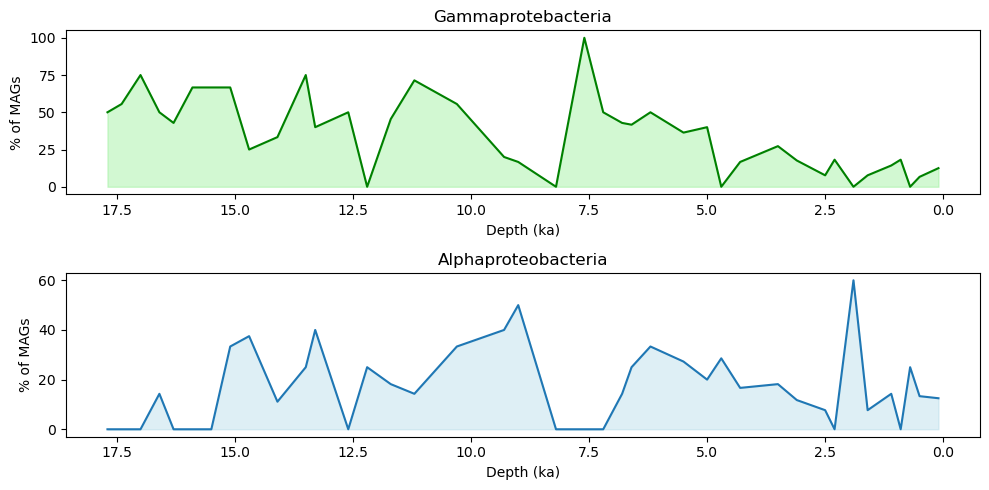

In [4]:
df = df_gtdbtk[['Sample', 'class','# bins']]

def gamma_alpha_bac_plot(df,level,l,plot=True):
    if plot:
        fig, axes = plt.subplots(2,1,figsize=(10,5))

    total_bins = df.groupby('Sample')[level].sum().reset_index()

    pivot_df = pd.pivot_table(df,index='class', columns='Sample', values=level, aggfunc='sum', fill_value=0).reset_index()
 

    df_gamma = pivot_df.where(pivot_df['class'] == 'Gammaproteobacteria').dropna().set_index('class')
    df_gamma_transposed = df_gamma.T.reset_index()
    df_gamma_merged = df_gamma_transposed.merge(total_bins, on='Sample', suffixes=('','_total'))
    df_gamma_merged['Prob'] = (df_gamma_merged['Gammaproteobacteria'] / df_gamma_merged[level])*100

    if plot:
        axes[0].plot(df_gamma_merged['Sample'],df_gamma_merged['Prob'], color='green')
        axes[0].invert_xaxis()
        axes[0].set_title('Gammaprotebacteria')
        axes[0].set_xlabel('Depth (ka)')
        axes[0].set_ylabel(f'% of {l}')
        axes[0].fill_between(df_gamma_merged['Sample'], df_gamma_merged['Prob'], color='lightgreen', alpha=0.4)

    df_alpha = pivot_df.where(pivot_df['class'] == 'Alphaproteobacteria').dropna().set_index('class')
    df_alpha_transposed = df_alpha.T.reset_index()
    df_alpha_merged = df_alpha_transposed.merge(total_bins, on='Sample', suffixes=('','_total'))
    df_alpha_merged['Prob'] = (df_alpha_merged['Alphaproteobacteria'] / df_alpha_merged[level])*100

    if plot:
        axes[1].plot(df_alpha_merged['Sample'],df_alpha_merged['Prob'])
        axes[1].invert_xaxis()
        axes[1].set_title('Alphaproteobacteria')
        axes[1].set_xlabel('Depth (ka)')
        axes[1].set_ylabel(f'% of {l}')
        axes[1].fill_between(df_alpha_merged['Sample'], df_alpha_merged['Prob'], color='lightblue', alpha=0.4)
        plt.tight_layout()
    else:
        return df_alpha_merged, df_gamma_merged
gamma_alpha_bac_plot(df,'# bins','MAGs')

prevalence of MAGs from 5 genera in core and their quality

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Hydromicrobium'),
  Text(1, 0, 'Acidovorax'),
  Text(2, 0, 'Pararheinheimera'),
  Text(3, 0, 'Pseudomonas'),
  Text(4, 0, 'Pseudolabrys')])

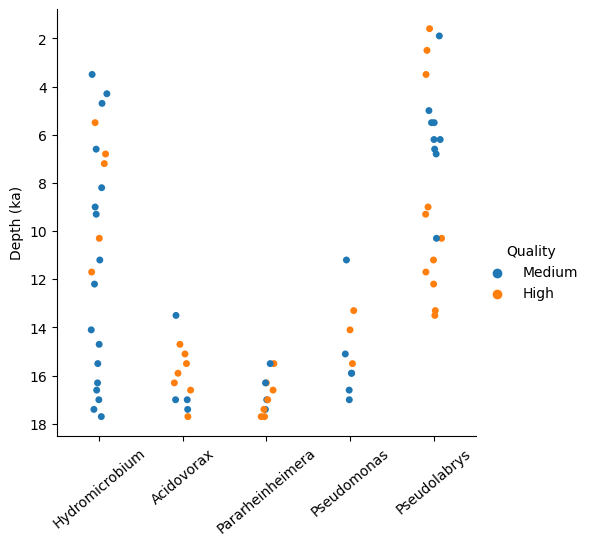

In [7]:
df_select = df_gtdbtk[(df_gtdbtk['genus'] == 'Hydromicrobium') | (df_gtdbtk['genus'] == 'Pseudolabrys') |(df_gtdbtk['genus'] == 'Acidovorax') | (df_gtdbtk['genus'] == 'Pararheinheimera')| (df_gtdbtk['genus'] == 'Pseudomonas')]
df_select = df_select[['Sample','genus', '# bins', 'checkm2_quality', 'bin']]

df_select['Quality'] = df_select['checkm2_quality']

df_select.sort_values('Sample', inplace=True, ascending=False)

sns.catplot(data=df_select, x='genus', y='Sample', hue='Quality').ax.invert_yaxis()
plt.ylabel('Depth (ka)')

plt.xlabel('')
plt.xticks(rotation=40)


prepare data for next plot with pydamage data and what contigs belong to what bin

In [8]:
# combine the df with pydamage data

df_pydamage= pd.read_csv("/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/mag/mag_results3/pydamage_table.csv",index_col=False)
df_pydamage['Sample'] = df_pydamage['Sample'].replace(megahit_name_age_dict)
df_pydamage.drop(df_pydamage[df_pydamage['Sample'].isin(megahit_duplicates_samples)].index, inplace=True)
df_pydamage.sort_values(by='Sample', inplace=True)

df_pydamage['Damaged'] = np.where((df_pydamage['predicted_accuracy']>= 0.5) & (df_pydamage['qvalue'] <= 0.05),'damage','no_damage')
df_pydamage.rename(columns={'reference':'contig_id'}, inplace=True)

df_bins_contigs = pd.read_csv('/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/mag/mag_results3/refined_bins_contigs_table.csv', index_col=False)
df_bins_contigs.drop(df_bins_contigs[df_bins_contigs['Sample'].isin(duplicate_samples)].index, inplace=True)
df_bins_contigs['Sample'] = df_bins_contigs['Sample'].replace(name_age_dict)

df_bins_damage = df_bins_contigs.merge(df_pydamage, on=['Sample','contig_id']).dropna()

df_bins_damage['bin'] = df_bins_damage['bin'].str[:-3]

df_bins_contigs.to_csv(f"/Net/Groups/pbtdata/01_RAG/09_sediments/tibetan_sediments/04-analysis/bins_contigs.csv", index=True)


percentage of damaged contigs in MAGs from 5 genera, according to pydamage

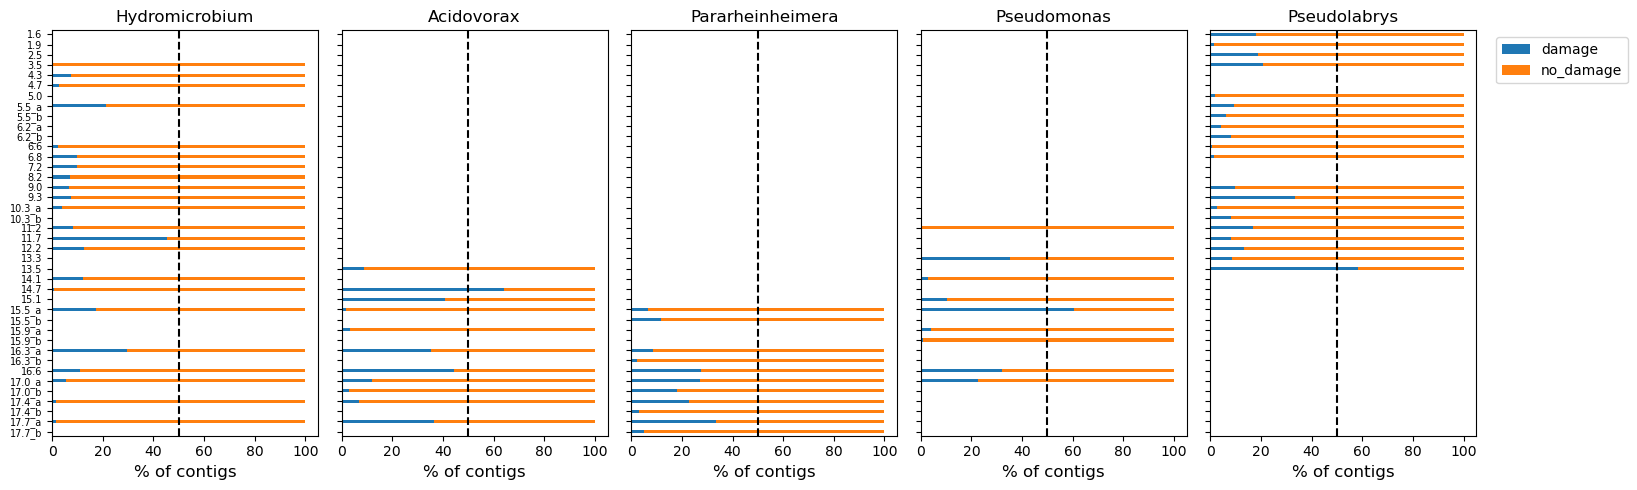

In [9]:
#plot the pydamage for the bins for each selcted genus

df_pydamage['Damaged'] = np.where((df_pydamage['predicted_accuracy']> 0.5) & (df_pydamage['qvalue'] < 0.05),'damage','no_damage')

df_bins_damage = df_bins_contigs.merge(df_pydamage, on=['Sample','contig_id']).dropna()

df_bins_damage['bin'] = df_bins_damage['bin'].str[:-3]

fig, axes = plt.subplots(1,5,figsize=(15, 5), sharey=True) #

df_select_damage = df_select.merge(df_bins_damage, on=['Sample','bin']).dropna()

all_samples = sorted(df_select_damage['Sample'].unique())
sample_positions = {sample: i for i, sample in enumerate(all_samples)}


def plot_pydamge_per_genus(genus, in_df,i):
    df = in_df[in_df['genus'] == genus]

    unique_bins = df['bin'].unique()

    data={
        'Sample' : [],
        'bin': [],
        'Damaged': [],
        '#contigs': []
    }

    for bin in unique_bins:
        count_condition_damage = ((df['bin'] == bin) & (df['Damaged'] == 'damage')).sum()
        count_condition_nodamage = ((df['bin'] == bin) & (df['Damaged'] == 'no_damage')).sum()
        sample = (df[df['bin'] == bin]['Sample'].unique())[0]
        data['Sample'].append(sample)
        data['bin'].append(bin)
        data['Damaged'].append('damage')
        data['#contigs'].append(count_condition_damage)

        data['Sample'].append(sample)
        data['bin'].append(bin)
        data['Damaged'].append('no_damage')
        data['#contigs'].append(count_condition_nodamage)
    
    for sample in all_samples:
        if sample not in data['Sample']:
            data['Sample'].append(sample)
            data['bin'].append('bin')
            data['Damaged'].append('damage')
            data['#contigs'].append(0)

            data['Sample'].append(sample)
            data['bin'].append('bin')
            data['Damaged'].append('no_damage')
            data['#contigs'].append(0)
    dup = [17.0,15.5, 16.3, 17.4, 17.7, 15.9, 5.5, 6.2, 10.3]
    for sample in dup:
        if data['Sample'].count(sample) == 2:
            data['Sample'].append(sample)
            data['bin'].append('bin2')
            data['Damaged'].append('damage')
            data['#contigs'].append(0)

            data['Sample'].append(sample)
            data['bin'].append('bin2')
            data['Damaged'].append('no_damage')
            data['#contigs'].append(0)

    df_counts= pd.DataFrame(data)
    
    pivot_df_counts = df_counts.pivot(index=['Sample','bin'], columns='Damaged', values='#contigs').fillna(0)
    pivot_df_counts.sort_index(ascending=False, inplace=True)

    total_contig_number=df_counts.groupby(['Sample','bin'])['#contigs'].sum().reset_index()
 

    df_pydamage_counts_merged = df_counts.merge(total_contig_number, on=['Sample','bin'], suffixes=('','_total'))


    df_pydamage_counts_merged['Prop'] = (df_pydamage_counts_merged['#contigs'] / df_pydamage_counts_merged['#contigs_total'])*100


    pivot_df_pydamage_counts_merged = df_pydamage_counts_merged.pivot(index=['Sample','bin'], columns='Damaged', values='Prop').fillna(0)
    pivot_df_pydamage_counts_merged.sort_index(ascending=False, inplace=True)

    # Create a stacked bar plot
    if i == 4:
        pivot_df_pydamage_counts_merged.plot(kind='barh', stacked=True, ax=axes[i],width=0.3)
    else:
        pivot_df_pydamage_counts_merged.plot(kind='barh', stacked=True, ax=axes[i],width=0.3, legend=False)
    y_ticks_dict = {}
    for j in range(len(pivot_df_pydamage_counts_merged.index)):
        y_ticks_dict[pivot_df_pydamage_counts_merged.index[j]] = pivot_df_pydamage_counts_merged.index[j][0]


    unique_values = []
    duplicates = []
    for value in y_ticks_dict.values():
        if value not in unique_values:
            unique_values.append(value)
        else:
            duplicates.append(value)

    dup_keys = {}
    for d in duplicates:
        keys_with_value = [key for key, value in y_ticks_dict.items() if value == d]

        dup_keys[d] = (keys_with_value[0][1],keys_with_value[1][1])
 
    for key in dup_keys:
        y_ticks_dict[(key,dup_keys[key][1])] = str(key) + "_a"
        y_ticks_dict[(key,dup_keys[key][0])] = str(key) + "_b"
    axes[i].set_xlabel("% of contigs", fontsize=12)
    axes[i].set_ylabel('', fontsize=12)
    axes[i].set_title(genus)
    axes[i].axvline(x=50, color='black', linestyle='--')
    axes[i].set_yticklabels(list(y_ticks_dict.values()),fontsize=7)

i=0
for genus in df_select_damage['genus'].unique():
    plot_pydamge_per_genus(genus, df_select_damage,i)
    i+=1


fig.tight_layout()
axes[4].legend(bbox_to_anchor=(1.05,1),loc='upper left')

regressionn plot with c to T transitions

/home/mkaiser/miniconda3/envs/statistics/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 0, "Position from 5' end(bp)")

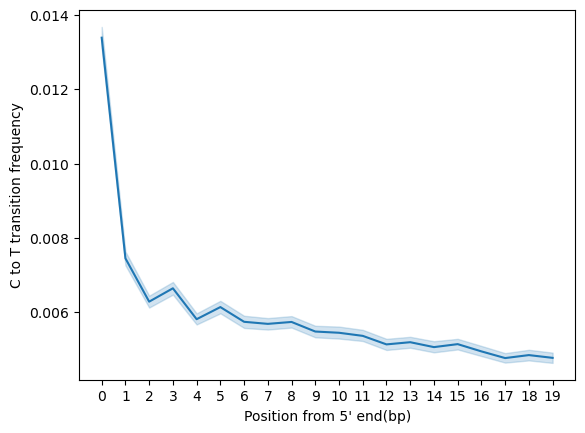

In [10]:
df_reg = df_select_damage[['Sample','bin','genus','CtoT-0', 'CtoT-1', 'CtoT-2',
       'CtoT-3', 'CtoT-4', 'CtoT-5', 'CtoT-6', 'CtoT-7', 'CtoT-8', 'CtoT-9',
       'CtoT-10', 'CtoT-11', 'CtoT-12', 'CtoT-13', 'CtoT-14', 'CtoT-15',
       'CtoT-16', 'CtoT-17', 'CtoT-18', 'CtoT-19']]

df_reg.drop(['Sample','bin','genus'], axis=1, inplace=True)
df_reg.reset_index(inplace=True)
rename_dict = {}
for p in range(20):
    rename_dict[f'CtoT-{p}'] = p

df_reg_pivot = df_reg.T.reset_index()
df_stacked = pd.DataFrame()
stacked_dict = {
    'Pos':[],
    'Value':[]
}

for i in range(len(df_reg_pivot.columns)-1):
    stacked_dict['Pos'] = stacked_dict['Pos'] + df_reg_pivot['index'].to_list()[1:]
    stacked_dict['Value'] = stacked_dict['Value'] + df_reg_pivot[i].to_list()[1:]

df_stacked = pd.DataFrame(stacked_dict)
df_stacked['Pos'] = df_stacked['Pos'].replace(rename_dict)

plt = sns.lineplot(df_stacked, x='Pos',y='Value')
plt.set_xticks(np.arange(0,20,1))
plt.set_ylabel('C to T transition frequency')
plt.set_xlabel("Position from 5' end(bp)")